In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        action_rewards = Q[observation]
        
        prob = np.zeros(nA)
        prob[  action_rewards.argmax() ] = 1 - epsilon + epsilon / nA
        prob[~ action_rewards.argmax() ] = epsilon / nA
        
        return prob
    return policy_fn

In [15]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function taht takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        print('\rEpisode {}/{}'.format(i_episode, num_episodes), end='')
        episode = []
        state = env.reset()
        while True:
            prob = policy(state)
            action = np.random.multinomial(1, prob).argmax()
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            
            if done:
                break
                
            state = next_state
            
        # Here we don't estimate V(s) as in the last exercise, instead
        # we estimate Q(s,a) given the last episode.
        for step in episode:
            st, ac, _ = step
            first_visit_idx = next(i for i,ep in enumerate(episode) 
                                   if ep[0] == st and ep[1] == ac)
            reward = sum([ep[2] * discount_factor ** i 
                          for i,ep in enumerate(episode[first_visit_idx:])])
            
            returns_sum[(st, ac)] += reward
            returns_count[(st, ac)] += 1.0
            
            # GLIE MC Control: Q[st][ac] = Q[st][ac] + (G_t - Q[st][ac])/ N[st][ac]
            Q[st][ac] += (reward - Q[st][ac]) / returns_count[(st,ac)]
            # Q[st][ac] = returns_sum[(st, ac)] / returns_count[(st, ac)]
    
        # GLIE MC Control: e / k to decay toward zero
        epsilon /= 2
            
    return Q, policy

In [16]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 499999/500000

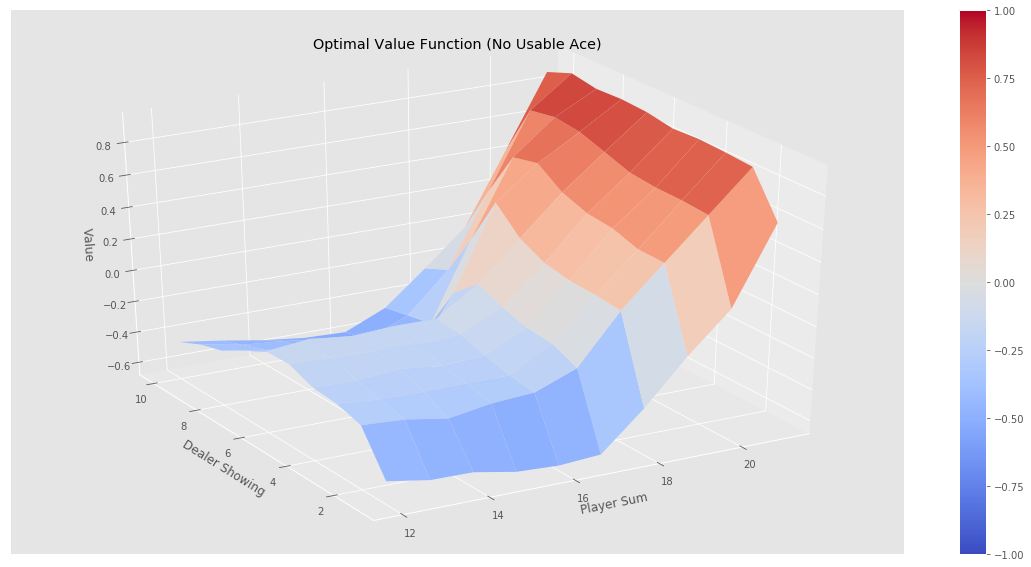

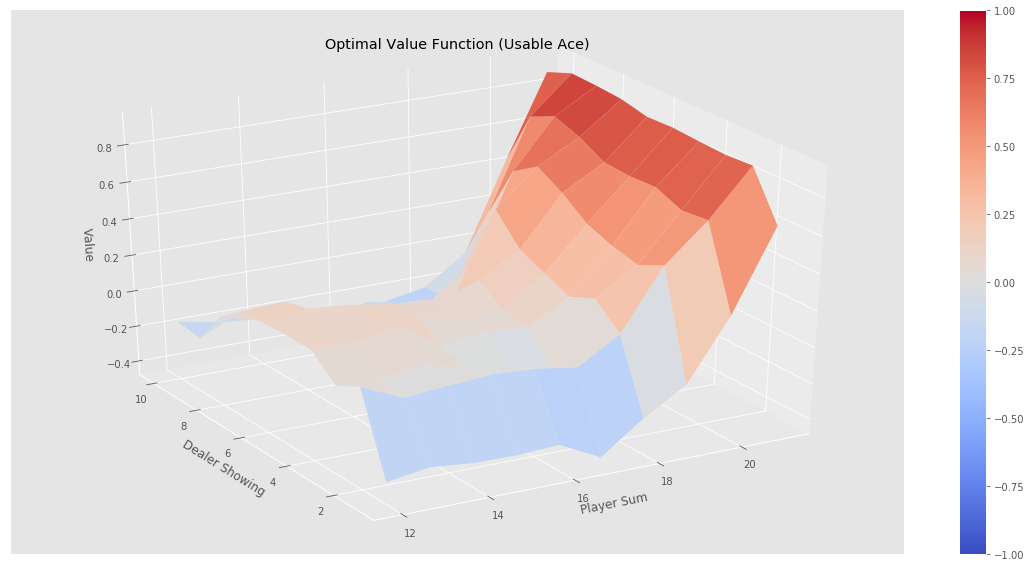

In [17]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")